<a href="https://www.kaggle.com/code/shravankumar147/exploring-janus-pro-1b-for-classification?scriptVersionId=219822930" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!git clone https://github.com/deepseek-ai/Janus.git

fatal: destination path 'Janus' already exists and is not an empty directory.


In [3]:
%cd /kaggle/working/Janus

/kaggle/working/Janus


In [4]:
!pip install -e .

Obtaining file:///kaggle/working/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=15932 sha256=5dffb255304e1a5dafe5f05145b65f42db8147c6a1fe7b7869bedb988137f52a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mc4p27_1/wheels/cb/20/db/a2e58bf4a9076003af4cdd6a476a8ae1a9936d9bf84bbcff86
Successfully built janus
  Attempting uninstall: janus
    Found existing installation: janus 1.0.0
    Uninstalling janus-1.0.0:
      Successfully uninstalled janus-1.0.0


In [5]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [6]:
# specify the path to the model
# model_path = "deepseek-ai/Janus-Pro-7B"
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: mask_prompt, ignore_id, num_image_tokens, sft_format, image_tag, add_special_token. 


In [7]:
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

In [8]:
# After loading the model:
total_params = sum(p.numel() for p in vl_gpt.parameters())
print(f"Parameters: {total_params / 1e9:.2f} B")          # Ex: ~2.00 B parameters
print(f"Memory: {total_params * 2 / (1024**3):.2f} GB")   # Ex: ~3.73 GB for float16

Parameters: 2.09 B
Memory: 3.89 GB


In [16]:
import requests
from io import BytesIO
import re
from PIL import Image

# def load_image_from_url(url):
#     """Load image from URL using requests"""
#     response = requests.get(url, timeout=10)
#     response.raise_for_status()
#     return Image.open(BytesIO(response.content)).convert("RGB")

In [14]:
image_url = "https://www.shutterstock.com/image-photo/dark-car-interior-steering-wheel-600nw-2445598523.jpg"
question = "Classify image as Interior or Exterior, Just Interior or Exterior is enough, no further description is required"

In [22]:
import os
def load_image_from_url(url: str, save_path: str = "/kaggle/working/"):
    """Download image from URL and save to Kaggle directory"""
    try:
        # Create directory if needed
        os.makedirs(save_path, exist_ok=True)
        
        # Download image
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        # Save to file
        filename = os.path.join(save_path, "downloaded_image.jpg")
        with open(filename, 'wb') as f:
            f.write(response.content)
            
        # Verify and load
        img = Image.open(filename).convert("RGB")
        return img
    
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

In [23]:
# Load image directly from URL
image = load_image_from_url(image_url)

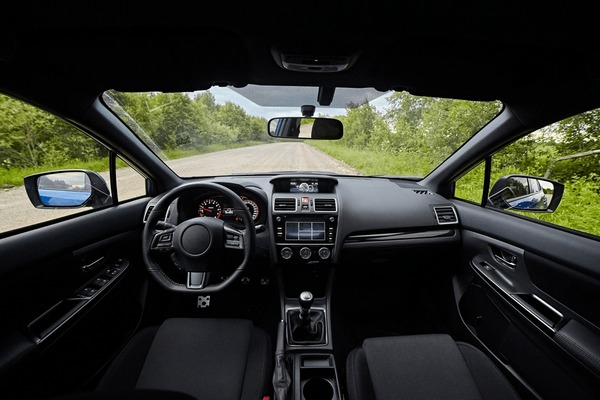

In [30]:
image

In [32]:
from transformers import AutoModelForCausalLM, StoppingCriteria, StoppingCriteriaList
# Custom stopping criteria
class StopOnFirstToken(StoppingCriteria):
    def __call__(self, input_ids, scores, **kwargs):
        # Stop after the first non-pad token is generated
        return input_ids.shape[1] >= 1

In [35]:
# Build conversation
question = "Classify image as Interior or Exterior. Just Interior or Exterior is enough."
conversation = [
    {"role": "User", "content": f"<image_placeholder>\n{question}", "images": ["/kaggle/working/downloaded_image.jpg"]},
    {"role": "Assistant", "content": ""},
]

In [36]:
# conversation = [
#     {
#         "role": "<|User|>",
#         "content": f"<image_placeholder>\n{question}",
#         "images": ["/kaggle/working/downloaded_image.jpg"],
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

In [25]:
# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

In [31]:
inputs_embeds

tensor([[[-2.9182e-04,  5.1880e-03, -3.0469e-01,  ..., -7.4463e-03,
           4.5471e-03,  6.0425e-03],
         [-4.0283e-03, -1.5234e-01,  3.6719e-01,  ...,  4.4141e-01,
          -1.1816e-01,  3.9062e-02],
         [ 5.5908e-02,  6.6895e-02,  1.3855e-02,  ..., -3.0859e-01,
          -6.4941e-02, -1.6699e-01],
         ...,
         [ 4.1016e-02,  6.9885e-03, -6.6406e-02,  ...,  9.5215e-03,
           4.4189e-02, -4.2969e-02],
         [-1.5320e-02,  2.2339e-02,  4.3335e-03,  ...,  2.4986e-04,
           2.4048e-02,  7.2002e-05],
         [-1.1035e-01,  4.4678e-02, -1.0107e-01,  ...,  1.9434e-01,
           1.5723e-01, -8.6426e-02]]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<IndexPutBackward0>)

In [26]:
# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

In [27]:
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
Classify image as Interior or Exterior, Just Interior or Exterior is enough, no further description is required

<|Assistant|>: The image is of an interior of a car.


In [46]:
# Generate response
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=10,
    do_sample=False,
    use_cache=True,
    # stopping_criteria=StoppingCriteriaList([StopOnFirstToken()]),
)

# # Extract classification
# answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
# classification = answer.split()[0].strip().capitalize()
# print(classification)  # Output: Interior

In [47]:
# Extract classification
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
classification_match = re.search(r"\b(Interior|Exterior)\b", answer, re.IGNORECASE)

print("Raw Answer:", answer)  # Debugging line
classification = classification_match.group(0).capitalize() if classification_match else "Unknown"
print(classification)

Raw Answer: The image is of an interior.
Interior
